# Multi-class Sentiment Analysis

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
import re
import nltk
from nltk.corpus import stopwords
tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

#Performance related
from sklearn.metrics import hamming_loss, accuracy_score, classification_report, roc_auc_score, confusion_matrix

## Exploratory Data Analysis

### Reading Data

In [ ]:
kindle_df_raw = pd.read_csv('kindle.csv',parse_dates=['reviewTime'])

NOTE: The size of this dataset file is 275.2 MB. Therefore the above code where pd.read_csv( ) has been used to read the data works fine. However, for larger datasets of sizes varying from 500 MB to 5 TB or more, this method of reading data is not efficient. Hence, for such cases, the recoomendation is to use open( ) function for reading data with readlines( ) method.

In [ ]:
kindle_df_raw.shape

(410695, 11)

In [ ]:
# Filtering for June onwards
kindle_df = kindle_df_raw[kindle_df_raw.reviewTime >= '2014-06-01']

In [ ]:
kindle_df.shape

(115093, 11)

In [ ]:
kindle_df = kindle_df.iloc[:,[2,4,5,6,-2]]
kindle_df = kindle_df.reset_index(drop='True')
kindle_df.columns = ['product_id','rating','review','review_date','review_summary']

In [ ]:
kindle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115093 entries, 0 to 115092
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   product_id      115093 non-null  object        
 1   rating          115093 non-null  int64         
 2   review          115093 non-null  object        
 3   review_date     115093 non-null  datetime64[ns]
 4   review_summary  115093 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 4.4+ MB


In [ ]:
kindle_df.head(2)

,product_id,rating,review,review_date,review_summary
0,B000F83SZQ,4,I enjoyed this one tho I'm not sure why it's c...,2014-06-10,Nice old fashioned story
1,B000FC26RI,4,I thought it would be instructive to compare t...,2014-06-21,Compare and contrast for a better understanding


In [ ]:
print(kindle_df.review_date.min())
print(kindle_df.review_date.max())

2014-06-01 00:00:00
2014-07-23 00:00:00


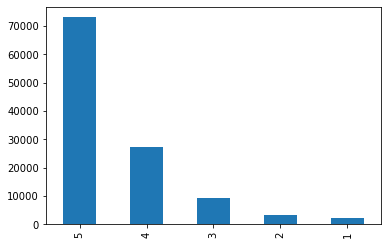

In [ ]:
#Rating Distribution
kindle_df.rating.value_counts().plot(kind='bar')
plt.show()

### Label assignment

In [ ]:
kindle_df['sentiment'] = kindle_df['rating'].apply(lambda x: "positive" if x>3 else ("negative" if x<3 else "neutral"))

In [ ]:
kindle_df_2 = kindle_df[['review','sentiment']]

In [ ]:
kindle_df_2.sentiment.value_counts()

positive    100379
neutral       9367
negative      5347
Name: sentiment, dtype: int64

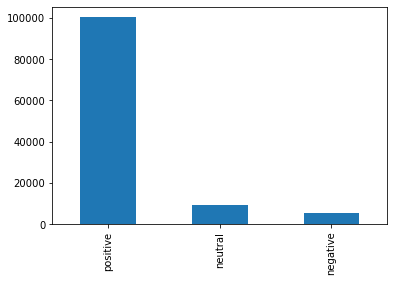

In [ ]:
kindle_df_2.sentiment.value_counts().plot(kind='bar')
plt.show()

## Data Pre-processing

In [ ]:
# Default stopwords list from package
stop_words = set(stopwords.words('english'))
stop_words_custom = list(stop_words)

# Remove punctuation from stopwords
temp = []
for i in stop_words_custom:
    temp.append(re.sub(r'[^a-z0-9\s]', '', i))

# Updating stopwords list
to_add = ['im', 'its']
stops = ["not","doesnt","didnt","wouldnt","shouldnt","couldnt","very","too","really","so"]
custom_stopwords = list(set(temp) - set(stops) | set(to_add))

In [ ]:
def clean(review_text):
    review_text = str(review_text).lower() # convert to lowercase
    #review_text = re.sub('\[.*?\]', '', review_text)
    review_text = re.sub('https?://\S+|www\.\S+', '', review_text) # Remove URls
    review_text = re.sub('<.*?>+', '', review_text)
    review_text = re.sub(r'[^a-z0-9\s]', '', review_text) # Remove punctuation
    review_text = re.sub('\n', '', review_text)
    review_text = re.sub('\w*\d\w*', '', review_text)

    review_text = re.sub('\s+',' ', review_text) #replace_multiple_spaces_with_single_space
    return(review_text)

In [ ]:
kindle_df_3 = kindle_df_2.copy()
kindle_df_3['review'] = kindle_df_3['review'].apply(clean)

In [ ]:
# Removing stopwords
kindle_df_3['reviews_cleaned'] = kindle_df_3['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom_stopwords)]))


In [ ]:
kindle_df_4 = kindle_df_3[['reviews_cleaned','sentiment']]
kindle_df_4.head(2)

,reviews_cleaned,sentiment
0,enjoyed one tho not sure called amy brewster m...,positive
1,thought would instructive compare charles john...,positive


## Train-test split (70:30 ratio)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(kindle_df_4['reviews_cleaned'], kindle_df_4['sentiment'], 
                                                    test_size=0.3, random_state=42, 
                                                    stratify=kindle_df_4['sentiment'].values)

In [ ]:
train_df = pd.DataFrame(dict(review = X_train, sentiment = y_train)).reset_index(drop=True)
test_df = pd.DataFrame(dict(review = X_test, sentiment = y_test)).reset_index(drop=True)

In [ ]:
train_df.shape

(80565, 2)

In [ ]:
train_df.sentiment.value_counts()

positive    70265
neutral      6557
negative     3743
Name: sentiment, dtype: int64

## Upsampling train dataset

In [ ]:
review_pos =  train_df[(train_df['sentiment']=="positive")]
review_neg = train_df[(train_df['sentiment']=="negative")]
review_neut = train_df[(train_df['sentiment']=="neutral")]

In [ ]:
review_neg_upsample = resample(review_neg, 
                                 replace=True,    #sample with replacement
                                 n_samples= 70265, #to match majority class
                                 random_state=42)  #reproducible results

review_neut_upsample = resample(review_neut,
                                 replace=True,
                                 n_samples= 70265,
                                 random_state=42)

In [ ]:
kindle_df_train = pd.concat([review_pos,review_neg_upsample,review_neut_upsample])

In [ ]:
kindle_df_train.shape

(210795, 2)

In [ ]:
kindle_df_train.sentiment.value_counts()

neutral     70265
negative    70265
positive    70265
Name: sentiment, dtype: int64

## Baseline Models

In [ ]:
X_train_up = kindle_df_train['review']
y_train_up = kindle_df_train["sentiment"]

### Multinomial Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
# Creating a pipeline
model = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=1))

In [ ]:
# Fitting the model with training set
model.fit(X_train_up, y_train_up)
# Predicting labels for the test set
labels = model.predict(X_test)

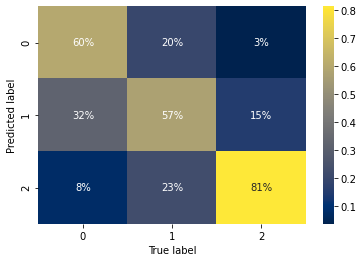

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Create the confusion matrix
conf_mat = confusion_matrix(y_test, labels, normalize="true")
# Plot the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis"
    #, xticklabels = y_train_up , yticklabels = y_train_up
    )
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

In [ ]:
pd.Series(labels).value_counts()

positive    25293
neutral      6663
negative     2572
dtype: int64

In [ ]:
print(classification_report(y_test, labels))

              precision    recall  f1-score   support

    negative       0.37      0.60      0.46      1604
     neutral       0.24      0.57      0.34      2810
    positive       0.97      0.81      0.89     30114

    accuracy                           0.78     34528
   macro avg       0.53      0.66      0.56     34528
weighted avg       0.88      0.78      0.82     34528



### Logistic Regression

In [ ]:

# test classification dataset
from collections import Counter
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)
# summarize the dataset
print(X.shape, y.shape)
print(Counter(y))

In [ ]:
# Fit the CountVectorizer to the training data

# transform the documents in the training data to a document-term matrix
vect = CountVectorizer().fit(X_train_up)
X_train_vectorized = vect.transform(X_train_up)

# Train the model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_vectorized, y_train_up)

# Predict the transformed test documents
predictions = model.predict(vect.transform(X_test))


/Users/naveenkumar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


NameError: name 'roc_auc_score' is not defined

In [ ]:
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['intense' 'deserves' 'discover' 'intrigue' 'complaint' 'memory'
 'fantastic' 'talented' 'compelling' 'packed']

Largest Coefs: 
['refund' 'hill' 'disappointing' 'absurd' 'ridiculous' 'stinks'
 'disgusting' 'bam' 'unreadable' 'deleted']


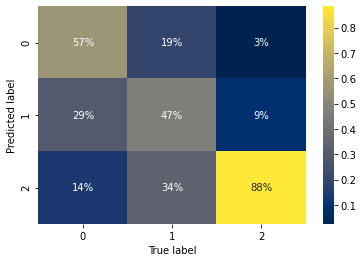

In [ ]:
# Create the confusion matrix
conf_mat = confusion_matrix(y_test, predictions, normalize="true")
# Plot the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis"
    #, xticklabels = y_train_up , yticklabels = y_train_up
           )
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()


## Appendix

In [ ]:
# kindle_df[kindle_df['rating'] == 3].review

In [ ]:
# x = kindle_df.iloc[[114981]]['review']
# x.iloc[0]